In [49]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import pandas as pd


In [147]:
def plot_polygons(geoms, ax, values=None, colormap='Set1', facecolor=None, edgecolor=None,
                            alpha=1.0, linewidth=1.0, **kwargs):
    # Makes a MatPlotLib PatchCollection out of Polygon and/or MultiPolygon geometries 
    # Thanks to http://stackoverflow.com/a/33753927
    import shapely
    from matplotlib.collections import PatchCollection
    from matplotlib.patches import Polygon
    
    patches = []
    newvals = []
    for polynum in range(len(geoms)):
        poly = geoms.iloc[polynum]
        if type(poly) != shapely.geometry.polygon.Polygon:
            for currpoly in poly.geoms:
                a = np.asarray(currpoly.exterior)
                patches.append(Polygon(a))
                if values is not None:
                    newvals.append(values.iloc[polynum])
        else:
            a = np.asarray(poly.exterior)
            patches.append(Polygon(a))
            if values is not None:
                newvals.append(values.iloc[polynum])

    patches = PatchCollection(patches, 
                              facecolor=facecolor, linewidth=linewidth, edgecolor=edgecolor, alpha=alpha, 
                              **kwargs)
    if values is not None:
        patches.set_array(np.asarray(newvals))
        patches.set_cmap(colormap)
        norm = matplotlib.colors.Normalize()
        norm.autoscale(newvals)
        patches.set_norm(norm)
    ax.add_collection(patches, autolim=True)
    ax.set_aspect('equal')
    ax.autoscale_view()
    return patches


In [148]:
import os
os.chdir('/Users/dosullivan/Documents/teaching/Geog88/Labs/data')

In [149]:
quakes = gpd.read_file('earthquakes.shp')
quakes['count'] = 1
quakes.head()

,DAY,DEATHS,EQ_PRIMARY,FLAG_TSUNA,FOCAL_DEPT,I_D,LATITUDE,LONGITUDE,MONTH,YEAR,geometry,count
0,11,None,7.8,None,None,2566,36.5,133.5,1,1900,POINT (133.5 36.5),1
1,20,None,7.4,None,10.000000,2569,20.0,-105.0,1,1900,POINT (-105 20),1
2,16,None,7.8,None,60.000000,2571,20.0,-105.0,5,1900,POINT (-105 20),1
3,21,None,7.5,None,60.000000,2573,10.0,-85.5,6,1900,POINT (-85.5 10),1
4,29,None,7.6,None,33.000000,2575,-10.0,165.0,7,1900,POINT (165 -10),1


In [223]:
import shapely.geometry
import math

# makes hex centers for the specified bounding box and number of rows
def make_centers(xmin=-180, xmax=180, ymin=-85, ymax=85, nrows=10):
    row_spacing = (ymax - ymin) / nrows
    col_spacing = 2 / math.sqrt(3) * row_spacing
    ncols = (xmax - xmin) / col_spacing
    x = []
    y = []
    for r in range(int(nrows + 0.5)):
        offset = 0.5 * (r % 2)
        x += [(c + 0.25 + offset) * col_spacing + xmin for c in range(int(ncols + 0.5))] 
        y += [(r + 0.5) * row_spacing + ymin] * int(ncols + 0.5)
    return (x, y)

# makes hexagons returning a list of shapely.geometry.polygon.Polygons
# first calls make_centers to determine hexagon centers 
def make_hexes(xmin=-175, xmax=175, ymin=-85, ymax=85, nrows=10):
    centers = make_centers(xmin, xmax, ymin, ymax, nrows)
    radius = (centers[0][1] - centers[0][0]) / math.sqrt(3)
    hexes = []
    for (x, y) in zip(centers[0], centers[1]):
        this_hex = []
        for theta in [(1/6 + i/3) * math.pi for i in range(6)]:
            this_hex.append((x + radius * math.cos(theta), y + radius * math.sin(theta)))
        hexes.append(shapely.geometry.polygon.Polygon(this_hex))
    return hexes

def get_hexbins(pts, nrows=10):
    import geopandas as gpd
    
    b = pts.bounds
    hexes = gpd.GeoSeries(make_hexes(nrows=nrows, 
                                     xmin=min(b.minx), 
                                     xmax=max(b.maxx), 
                                     ymin=min(b.miny), 
                                     ymax=max(b.maxy)))
    hexes.crs = pts.crs
    return gpd.GeoDataFrame(geometry=hexes)

def hexbin_density(pts, nrows=10):
    pts['count'] = 1
    hb = get_hexbins(pts, nrows=10)
    p_counts = gpd.sjoin(pts, hb, how='inner', 
                         op='within')[['index_right', 'count']].groupby(['index_right'], as_index=False).sum()
    p_density = hb.merge(p_counts, how='inner', left_index=True, right_on='index_right')[['geometry', 'count']]
    return p_density, hb

In [224]:
quake_density, hexbins = hexbin_density(quakes, nrows=15)

fig, ax = plt.subplots(figsize=(12,6))
ax.set_aspect('equal')
hexbins.plot(ax=ax, facecolor='w', edgecolor='k', linewidth=0.1)
quake_density.plot(ax=ax, column='count', scheme='quantiles', cmap='Reds', linewidth=0.1)
quakes.plot(ax=ax, color='k')

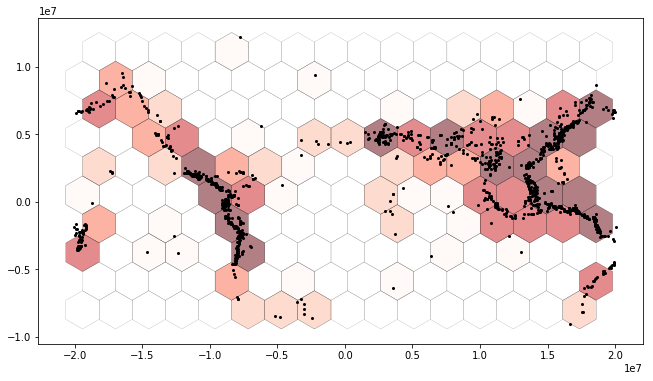

In [228]:
quake_density, hexbins = hexbin_density(quakes.to_crs(epsg=3857), nrows=15)

fig, ax = plt.subplots(figsize=(12,6))
ax.set_aspect('equal')
hexbins.plot(ax=ax, facecolor='w', edgecolor='k', linewidth=0.1)
quake_density.plot(ax=ax, column='count', scheme='quantiles', cmap='Reds', linewidth=0.1)
quakes.to_crs(epsg=3857).plot(ax=ax, color='k')

In [100]:
extent = shapely.geometry.polygon.Polygon([[-179,-80], [-179,80], [179,80], [179,-80]])

In [101]:
extent = gpd.GeoSeries([extent])
extent.crs = {'init' :'epsg:4326'}
world = gpd.GeoDataFrame(geometry=extent)

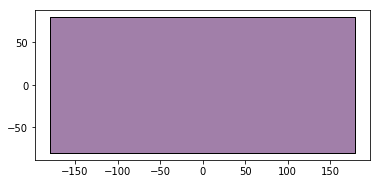

In [102]:
world.plot()

In [109]:
bb = quakes.bounds
min(bb.minx), max(bb.maxx), min(bb.miny), max(bb.maxy)

(-179.98400000000001, 180.0, -62.877000000000002, 73.122)

In [131]:
7 % 4

3

In [219]:
int(9.6)

9